<a href="https://colab.research.google.com/github/Jaesu26/dacon-basic/blob/main/2022-12-29-%ED%95%B4%EC%99%B8%EB%B6%80%EB%8F%99%EC%82%B0-%EC%9B%94%EC%84%B8-%EC%98%88%EC%B8%A1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 해외 부동산 월세 예측 AI 경진대회

In [1]:
!pip install pytorch-lightning==1.8.3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 798 kB 5.8 MB/s 
     |████████████████████████████████| 125 kB 52.5 MB/s 
     |████████████████████████████████| 512 kB 50.2 MB/s 
     |████████████████████████████████| 88 kB 6.0 MB/s 
  Created wheel for fire: filename=fire-0.5.0-py2.py3-none-any.whl size=116949 sha256=b34e371cf98d9ef4df84e906ef97fcc37e42b0f0b6985ca17a98f755ea6f9a4e
  Stored in directory: /root/.cache/pip/wheels/5b/eb/43/7295e71293b218ddfd627f935229bf54af9018add7fbb5aac6
Successfully built fire


`-` 런타임 재시작

## 데이터 불러오기

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import random
import easydict
import logging
import functools
import os
import gc

from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.metrics import mean_absolute_error

from abc import ABC, abstractmethod
from typing import Dict, List, Optional, Tuple, Union, Any, Callable, Type
from numpy.typing import NDArray

from tqdm.auto import tqdm
from copy import deepcopy
from glob import glob

warnings.filterwarnings('ignore') 

In [3]:
from google.colab import drive

drive.mount('/content/drive')  # 구글코랩과 구글드라이브 연결

Mounted at /content/drive


In [4]:
%cd /content/drive/MyDrive/Colab Notebooks/해외부동산-월세-예측

/content/drive/MyDrive/Colab Notebooks/해외부동산-월세-예측


- 데이터 불러오기

In [13]:
df = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')
submission = pd.read_csv('./data/sample_submission.csv')

df = df.drop('ID', axis=1)
test = test.drop('ID', axis=1)

df['bedrooms'] = df['bedrooms'].astype(str)
test['bedrooms'] = test['bedrooms'].astype(str)

- 하이퍼파라미터 

In [43]:
args = easydict.EasyDict({
    'weight_path':'./weights',
    'num_classes':1,
    'num_folds':5,
    'max_epochs':50,
    'bs':128,   # batch size
    'lr':1e-3,  # learning rate
    'gradient_clip_val':1.0,
    'seed':22,
    'log_interval':10
})

- 가중치 저장폴더

In [9]:
def create_folder(path: str) -> None:
    try:
        if not os.path.exists(path):
            os.makedirs(path)
    except OSError as error:
        print(error)

In [10]:
create_folder(args.weight_path)

## 시각화 및 전처리

In [11]:
sns.set_theme(style='white')

In [12]:
quality_columns = df.columns[(df.dtypes == int) | (df.dtypes == float)]
quantity_columns = df.columns[(df.dtypes == 'object')]

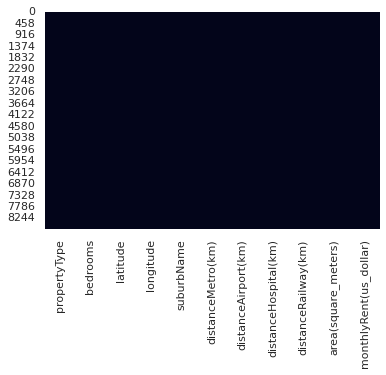

In [ ]:
sns.heatmap(df.isnull(), cbar=False)

`-` 결측치는 없다

### 범주형 변수

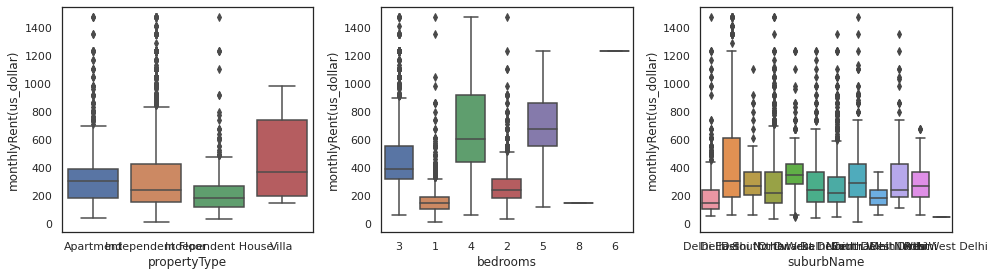

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(14, 4))
for col, ax in zip(quantity_columns, axs.flatten()):
    sns.boxplot(data=df, y='monthlyRent(us_dollar)', x=col, ax=ax)

fig.tight_layout()

`-` `suburbName` 변수에 경우 `West Delhi`와 `Delhi West`가 중복된 것으로 보여 이를 병합하겠다 (`North`도 마찬가지)

`-` 또한, 새로운 지역이 인풋으로 들어오는 경우를 대비해 이를 `Other`로 지정하겠다

In [16]:
tmp = df.suburbName.unique()
df.loc[df['suburbName'] == 'Delhi West', ['suburbName']] = 'West Delhi'
df.loc[df['suburbName'] == 'Delhi North', ['suburbName']] = 'North Delhi'
df.loc[df['suburbName'].apply(lambda x: x not in tmp), 'suburbName'] = 'Other'

test.loc[test['suburbName'] == 'Delhi West', ['suburbName']] = 'West Delhi'
test.loc[test['suburbName'] == 'Delhi North', ['suburbName']] = 'North Delhi'
test.loc[test['suburbName'].apply(lambda x: x not in tmp), 'suburbName'] = 'Other'

`-` `bedrooms` 변수는 5이상의 값을 가지는 경우가 매우 적어 이들을 5로 통합하겠다

In [17]:
df['bedrooms'] = df['bedrooms'].apply(lambda x: x if x < '5' else '5')
test['bedrooms'] = test['bedrooms'].apply(lambda x: x if x < '5' else '5')

`-` `propertyType` 변수의 경우 새로운 지역이 인풋으로 들어오는 경우를 대비해 최빈값인 `Independent Floor`로 지정하겠다

In [18]:
tmp = df.propertyType.unique()
# df.loc[df['propertyType'].apply(lambda x: x not in tmp), 'propertyType'] = 'Independent Floor'
test.loc[test['propertyType'].apply(lambda x: x not in tmp), 'propertyType'] = 'Independent Floor'

`-` `suburbName` 변수의 경우 새로운 지역이 인풋으로 들어오는 경우를 대비해 최빈값인 `Delhi South `로 지정하겠다

In [19]:
tmp = df.suburbName.unique()
# df.loc[df['suburbName'].apply(lambda x: x not in tmp), 'suburbName'] = 'Delhi South'
test.loc[test['suburbName'].apply(lambda x: x not in tmp), 'suburbName'] = 'Delhi South'

### 양적 변수

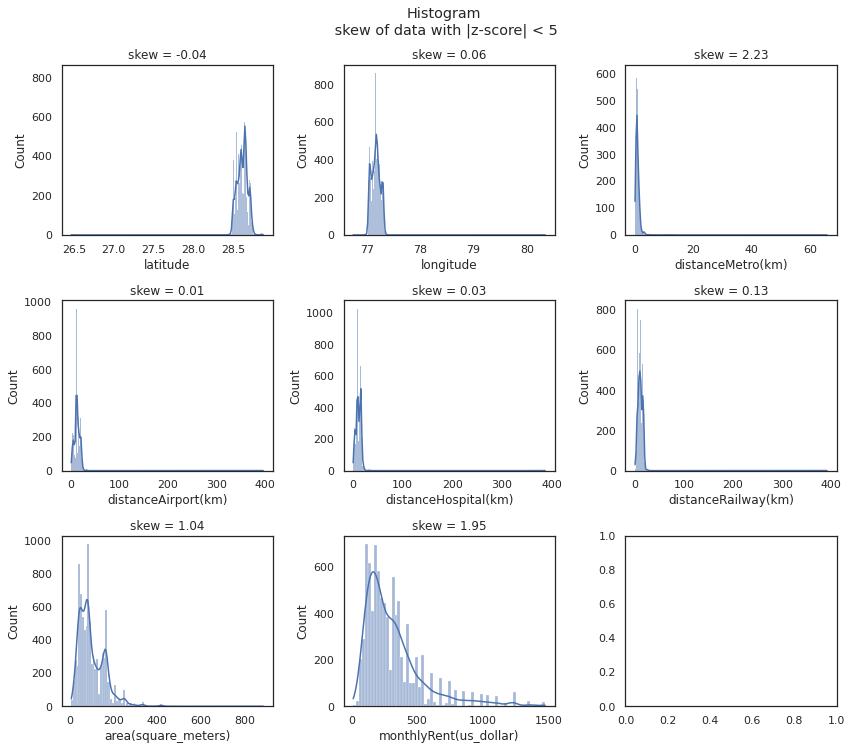

In [ ]:
fig, axs = plt.subplots(3, 3, figsize=(12, 10))
for col, ax in zip(quality_columns, axs.flatten()):
    mean, std = df[col].mean(), df[col].std()
    z_upper, z_lower = mean + 5*std, mean - 5*std
    df_ = df[(df.loc[:, col] < z_upper) & (df.loc[:, col] > z_lower)]
    skew = round(df_[col].skew(), 2)
    sns.histplot(data=df, x=col, kde=True, ax=ax)
    ax.set_title(f'skew = {skew}')

fig.suptitle('Histogram\n skew of data with |z-score| < 5', x=0.52, y=1.04)
fig.tight_layout()

`-` 안방 개수는 숫자로 인코딩 되어있지만 사실상 범주형 변수이다

`-` 광역 도시권과의 거리, 면적과 월세는 오른쪽 꼬리가 긴 분포이다

`-` 로그변환을 통해 왜도를 줄이겠다

In [20]:
## 로그 변환
for col in ['distanceMetro(km)', 'area(square_meters)', 'monthlyRent(us_dollar)']:
    df[col] = df[col].apply(np.log1p)
    if col != 'monthlyRent(us_dollar)':
       test[col] = test[col].apply(np.log1p)

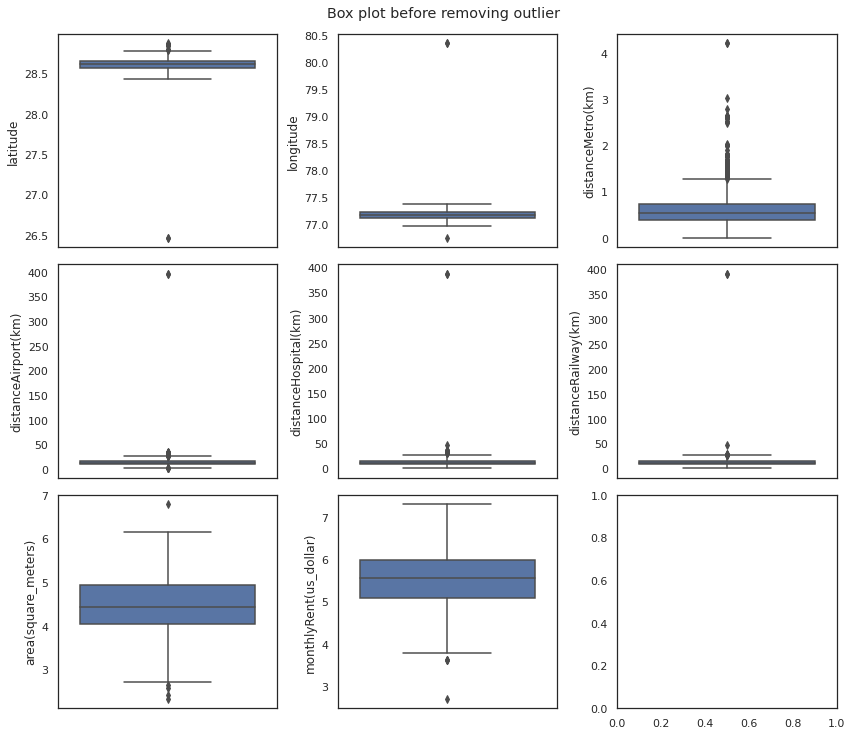

In [ ]:
fig, axs = plt.subplots(3, 3, figsize=(12, 10))
for col, ax in zip(quality_columns, axs.flatten()):
    sns.boxplot(y=df[col], ax=ax)

fig.suptitle('Box plot before removing outlier', x=0.52, y=1.02)
fig.tight_layout()

`-` 몇몇 양적 변수에 심각한 이상치가 존재한다

`-` z-score의 절댓값이 3을 넘어가는 데이터는 학습에 악영향을 끼친다고 판단하여 제거하겠다

In [21]:
## z-score의 절댓값이 3을 넘어가는 이상치 제거
for col in quality_columns:
    mean, std = np.mean(df[col]), np.std(df[col])
    z_upper, z_lower = mean + 3*std, mean - 3*std
    df = df[(df.loc[:, col] < z_upper) & (df.loc[:, col] > z_lower)]
    
df = df.reset_index(drop=True)

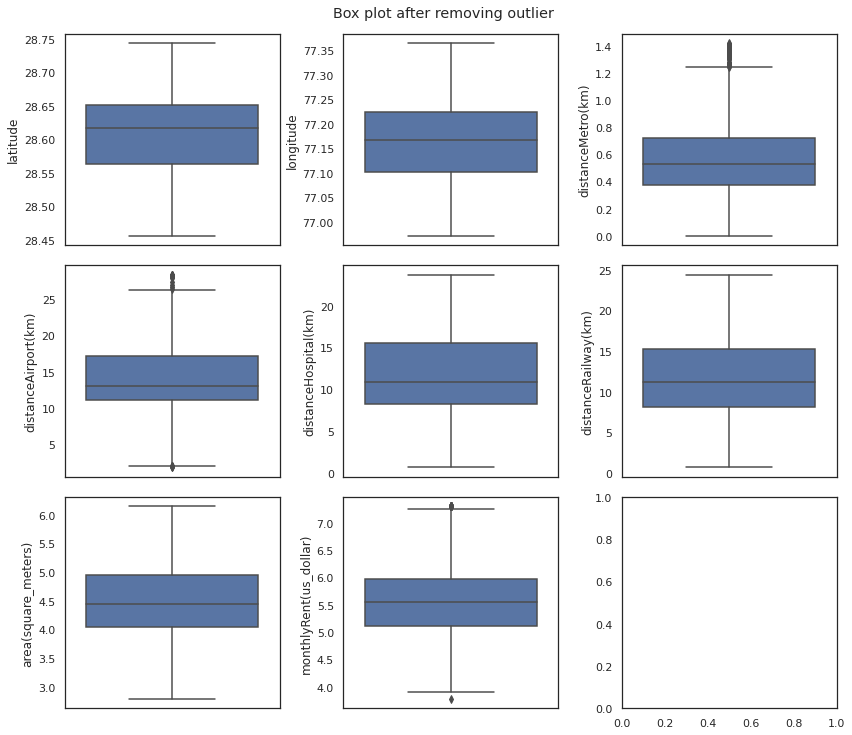

In [ ]:
fig, axs = plt.subplots(3, 3, figsize=(12, 10))
for col, ax in zip(quality_columns, axs.flatten()):
    sns.boxplot(y=df[col], ax=ax)

fig.suptitle('Box plot after removing outlier', x=0.52, y=1.02)
fig.tight_layout()

- 위도 경도와 월세간의 관계

`-` 위치에 따라 월세가 다를 수 있다

In [22]:
quartile_columns = ['latitude', 'longitude']

In [ ]:
df.assign(rent_bin = lambda x: x['monthlyRent(us_dollar)'].apply(np.searchsorted([5, 5.5, 6]))).\
groupby('rent_bin').agg({'latitude':np.mean, 'longitude':np.mean})

,latitude,longitude
rent_bin,,
0,28.606817,77.192340
1,28.615241,77.173531
2,28.616609,77.145203
3,28.608100,77.165210


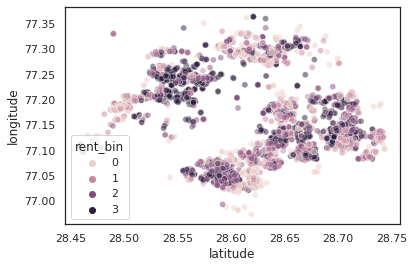

In [ ]:
sns.scatterplot(data=df.assign(rent_bin = lambda x: x['monthlyRent(us_dollar)'].apply(foo)),\
x='latitude', y='longitude', hue='rent_bin', alpha=0.5)

`-` 월세가 저렴한 곳은 다른 곳보다 경도가 조금 더 크다

`-` 격자로 구간을 나누어 사용하겠다

## 모델 학습 준비

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch import Tensor
from torch.utils.data import Subset, Dataset, DataLoader

import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping, StochasticWeightAveraging
from pytorch_lightning.loops.fit_loop import FitLoop
from pytorch_lightning.loops.loop import Loop
from pytorch_lightning.trainer.states import TrainerFn

In [23]:
def seed_everything(seed: int) -> None:
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True  
    torch.backends.cudnn.benchmark = False  
    torch.backends.cudnn.enabled = False

- 양적 변수 스케일링

In [24]:
## target
minmax_scaler = MinMaxScaler()  
df['monthlyRent(us_dollar)'] = minmax_scaler.fit_transform(df[['monthlyRent(us_dollar)']])


## target 외의 양적 변수
tmp = MinMaxScaler()
for col in quality_columns.drop('monthlyRent(us_dollar)'):
    if col not in quartile_columns:
        df[col] = tmp.fit_transform(df[[col]])
        test[col] = tmp.transform(test[[col]])

- 범주형 변수 원핫인코딩

In [25]:
onehot_encoder = OneHotEncoder(sparse=False)
quantity_columns = df.columns[df.dtypes == 'object']
for col in quantity_columns:
    df = pd.concat([df, pd.DataFrame(onehot_encoder.fit_transform(df[[col]]), columns=onehot_encoder.categories_[0])], axis=1)
    test = pd.concat([test, pd.DataFrame(onehot_encoder.transform(test[[col]]), columns=onehot_encoder.categories_[0])], axis=1)

df = df.drop(quantity_columns, axis=1)
test = test.drop(quantity_columns, axis=1)

- 위도, 경도 격자로 나누기

In [26]:
class QuartileEncoder:
    _feature_name = 'f'
    q = [0.25, 0.5, 0.75]

    def fit(self, X: NDArray[np.float], feature_name: Optional[str] = None) -> 'QuartileEncoder':
        self.quartile = np.quantile(X, self.q)
        self.num_classes = len(self.quartile) + 1
        self.categories = feature_name
        return self
    
    def transform(self, X: NDArray[np.float]) -> NDArray[np.float]:
        labels = np.searchsorted(self.quartile, X).reshape(-1)
        onehot = np.eye(self.num_classes)[labels]
        return onehot

    def fit_transform(self, X: NDArray[np.float], feature_name: Optional[str] = None) -> NDArray[np.float]:
        return self.fit(X, feature_name).transform(X)

    @property
    def categories(self) -> List[str]:
        return self._categories

    @categories.setter
    def categories(self, feature_name: Optional[str] = None) -> None:
        if feature_name is not None:
            self._categories = [feature_name + str(i) for i in range(self.num_classes)]
        else:
            self._categories = [self._feature_name + str(i) for i in range(self.num_classes)]
            QuartileEncoder._feature_name = ''.join([QuartileEncoder._feature_name, 'f'])

In [27]:
quartile_encoder = QuartileEncoder()
quartile_columns = ['latitude', 'longitude']
for col in quartile_columns:
    df = pd.concat([df, pd.DataFrame(quartile_encoder.fit_transform(df[col], col), columns=quartile_encoder.categories)], axis=1)
    test = pd.concat([test, pd.DataFrame(quartile_encoder.transform(test[col]), columns=quartile_encoder.categories)], axis=1)

df = df.drop(quartile_columns, axis=1)
test = test.drop(quartile_columns, axis=1)

- 데이터 셋과 데이터 로더

In [28]:
class CustomDataset(Dataset):
    def __init__(
        self, 
        X: NDArray[np.float],
        y: Optional[NDArray[np.int]] = None
    ) -> None:
        self.X = X
        self.y = y
    
    def __getitem__(self, idx: int) -> Union[Tuple[Tensor, Tensor, int], Tuple[Tensor, Tensor]]:
        X = torch.FloatTensor(self.X[idx])
        if self.y is not None:
            y = torch.FloatTensor(self.y[idx])  
            return X, y
        return X

    def __len__(self) -> int:
        return self.X.shape[0]

- 모델 선언

`-` ref: https://github.com/Lightning-AI/lightning/blob/master/examples/pl_loops/kfold.py


In [29]:
class BaseKFoldDataModule(pl.LightningDataModule, ABC):
    @abstractmethod
    def setup_folds(self, num_folds: int) -> None:
        pass

    @abstractmethod
    def setup_fold_index(self, fold_index: int) -> None:
        pass


class KFoldDataModule(BaseKFoldDataModule):
    def __init__(self, X, y, X_predict, **kwargs):
        super(KFoldDataModule, self).__init__()
        self.save_hyperparameters(logger=False)  
        self.X = X
        self.y = y
        self.X_predict = X_predict

    def setup(self, stage: str) -> None:
        self.dataset = CustomDataset(X, y)
        self.predict_dataset = CustomDataset(X_predict)

    def setup_folds(self, num_folds: int) -> None:
        self.num_folds = num_folds
        self.splits = [split for split in KFold(num_folds).split(range(len(self.dataset)))]

    def setup_fold_index(self, fold_index: int) -> None:
        train_indices, val_indices = self.splits[fold_index]
        self.train_dataset = Subset(self.dataset, train_indices)
        self.val_dataset = Subset(self.dataset, val_indices)

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.hparams.bs, shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.hparams.bs, shuffle=False)

    def predict_dataloader(self):
        return DataLoader(self.predict_dataset, batch_size=self.hparams.bs, shuffle=False)

In [57]:
def get_block(in_features, out_features, drop_prob=0.2):
    return nn.Sequential(
            nn.Linear(in_features, out_features),
            nn.BatchNorm1d(out_features),
            nn.GELU(),
            nn.Dropout(p=drop_prob)
        )
        

def init_weights(model):
    classname = model.__class__.__name__
    if classname.find('Linear') != -1:
        y = model.in_features
        model.weight.data.normal_(0.0, np.sqrt(2 / y))
        model.bias.data.fill_(0)
    elif classname.find('BatchNorm') != -1:
        model.weight.data.normal_(1.0, 0.02)
        model.bias.data.fill_(0)


class Regressor(nn.Module):
    def __init__(self, num_classes):
        super(Regressor, self).__init__()
        self.in_features_list = [32, 128, 256, 128]
        self.out_features_list = [128, 256, 128, 64]
        self.net = nn.Sequential(
            *[get_block(in_features, out_features) 
            for in_features, out_features in zip(self.in_features_list, self.out_features_list)]
        )
        self.fc = nn.Linear(self.out_features_list[-1], num_classes)  

    def forward(self, x):
        x = self.net(x)
        x = self.fc(x)
        return x 


class LightningRegressor(pl.LightningModule):
    def __init__(self, **kwargs):
        super(LightningRegressor, self).__init__()
        self.save_hyperparameters(logger=False)
        self.model = Regressor(self.hparams.num_classes).apply(init_weights)  

    def forward(self, x):
        return self.model(x)

    def on_train_start(self) -> None:
        self.log_dict({'fold':self.current_fold})

    def _shared_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.l1_loss(y_hat, y)
        return {'loss':loss, 'y':y, 'y_hat':y_hat}

    def training_step(self, batch, batch_idx):
        return self._shared_step(batch, batch_idx)

    def training_epoch_end(self, outputs):
        avg_loss = torch.stack([x['loss'] for x in outputs]).mean()
        if self.current_epoch % self.hparams.log_interval == 0:
            print(f'Epoch {self.current_epoch} | Train Loss: {avg_loss:.4f}', end=' '*2)

    def validation_step(self, batch, batch_idx):
        return self._shared_step(batch, batch_idx)

    def validation_epoch_end(self, outputs):
        y = torch.cat([x['y'] for x in outputs]).detach().cpu().numpy()
        y_hat = torch.cat([x['y_hat'] for x in outputs]).detach().cpu().numpy()
        val_mae = mean_absolute_error(np.expm1(minmax_scaler.inverse_transform(y)), np.expm1(minmax_scaler.inverse_transform(y_hat)))
        avg_loss = torch.stack([x['loss'] for x in outputs]).mean()
        self.log_dict({'val_loss':avg_loss, 'val_mae':val_mae}, logger=False)
        if self.current_epoch % self.hparams.log_interval == 0:
            print(f'Val Loss: {avg_loss:.4f}  Val MAE: {val_mae:.4f}')

    def predict_step(self, batch, batch_idx, dataloader_idx=0):
        x = batch
        pred = np.expm1(minmax_scaler.inverse_transform(self(x).detach().cpu().numpy()))
        return pred

    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), lr=args.lr)
        return optimizer

In [56]:
class KFoldLoop(Loop):
    def __init__(self, num_folds: int, export_path: str) -> None:
        super().__init__()
        self.num_folds = num_folds
        self.current_fold: int = 0
        self.export_path = export_path

    @property
    def done(self) -> bool:
        return self.current_fold >= self.num_folds

    def connect(self, fit_loop: FitLoop) -> None:
        self.fit_loop = fit_loop

    def reset(self) -> None:
        """Nothing to reset in this loop."""
        pass

    def on_run_start(self, *args: Any, **kwargs: Any) -> None:
        """Used to call `setup_folds` from the `BaseKFoldDataModule` instance and store the original weights of the
        model."""
        assert isinstance(self.trainer.datamodule, BaseKFoldDataModule)
        self.trainer.ckpt_paths = []
        self.trainer._callbacks = deepcopy(self.trainer.callbacks)
        self.trainer.datamodule.setup_folds(self.num_folds)
        self.lightning_module_state_dict = deepcopy(self.trainer.lightning_module.state_dict())

    def on_advance_start(self, *args: Any, **kwargs: Any) -> None:
        """Used to call `setup_fold_index` from the `BaseKFoldDataModule` instance."""
        print('\n'*2 + f'[{self.current_fold + 1} / {self.num_folds}] Fold Training......', end='\n'*2)
        assert isinstance(self.trainer.datamodule, BaseKFoldDataModule)
        self.trainer.datamodule.setup_fold_index(self.current_fold)
        self.trainer.lightning_module.current_fold = self.current_fold

    def advance(self, *args: Any, **kwargs: Any) -> None:
        """Used to the run a fitting and testing on the current hold."""
        self._reset_fitting()  # requires to reset the tracking stage.
        self.fit_loop.run()

    def on_advance_end(self) -> None:
        """Used to save the weights of the current fold and reset the LightningModule and its optimizers."""
        self.trainer.ckpt_paths.append(self.trainer.checkpoint_callback.best_model_path)
        self.trainer.callbacks = deepcopy(self.trainer._callbacks)  # reset callbacks

        # restore the original weights + optimizers and schedulers.
        self.trainer.lightning_module.load_state_dict(self.lightning_module_state_dict)
        self.trainer.strategy.setup_optimizers(self.trainer)
        self.replace(fit_loop=FitLoop)
        self.current_fold += 1

    def on_save_checkpoint(self) -> Dict[str, int]:
        # 중간에 학습 끊기고 처음부터 다시 시작하면 init 함수에 의해 현재 폴드 순서는 0으로 초기화됨
        # 그 당시 학습할 때 폴드 순서를 알기 위해선 현재 폴드 순서도 알아야 하므로 저장
        return {"current_fold": self.current_fold}

    def on_load_checkpoint(self, state_dict: Dict) -> None:
        self.current_fold = state_dict["current_fold"]

    def _reset_fitting(self) -> None:
        self.trainer.reset_train_dataloader()
        self.trainer.reset_val_dataloader()
        self.current_epoch = 0
        self.global_step = 0
        self.trainer.state.fn = TrainerFn.FITTING
        self.trainer.training = True
        self.trainer.should_stop = False

    def _reset_predicting(self) -> None:
        self.trainer.reset_predict_dataloader()
        self.trainer.state.fn = TrainerFn.PREDICTING
        self.trainer.predicting = True

    @property
    def global_step(self) -> int:
        return self.fit_loop.global_step

    @global_step.setter
    def global_step(self, value) -> None:
        self.fit_loop.global_step = value

    @property
    def current_epoch(self) -> int:
        return self.fit_loop.current_epoch

    @current_epoch.setter
    def current_epoch(self, value) -> None:
        self.fit_loop.current_epoch = value

    def __getattr__(self, key) -> Any:
        # requires to be overridden as attributes of the wrapped loop are being accessed.
        if key not in self.__dict__:
            return getattr(self.fit_loop, key)
        return self.__dict__[key]

    def __setstate__(self, state: Dict[str, Any]) -> None:
        self.__dict__.update(state)

## 모델 교차검증 및 예측

- 모델 k-fold 교차검증

In [32]:
y = df.pop('monthlyRent(us_dollar)').values.reshape(-1, 1)
X = df.to_numpy()
X_predict = test.to_numpy()

In [60]:
logging.getLogger('pytorch_lightning').setLevel(logging.ERROR)
seed_everything(args.seed)
model = LightningRegressor(**args)
datamodule = KFoldDataModule(X, y, X_predict, **args)

mc = ModelCheckpoint(dirpath=args.weight_path,
                     filename='{fold}-{epoch}-{val_mae:.2f}',
                     monitor='val_mae',
                     mode='min',
                     save_weights_only=True)

es = EarlyStopping(monitor='val_mae', 
                   patience=10,
                   verbose=False,
                   mode='min')

# swa = StochasticWeightAveraging(swa_lrs=1e-2)

trainer = pl.Trainer(
    max_epochs=args.max_epochs,
    num_sanity_val_steps=0,
    gradient_clip_val=args.gradient_clip_val,
    enable_progress_bar=False, 
    enable_model_summary=False,
    devices=1,
    accelerator='cpu',
    callbacks=[mc, es]
)

## 폴드를 담당하는 바깥 loop (폴드를 업데이트 시킴)
## 모델 학습을 담당하는 폴드 loop 내의 loop (This Loop iterates over the epochs to run the training)
internal_fit_loop = trainer.fit_loop
trainer.fit_loop = KFoldLoop(num_folds=args.num_folds, export_path=args.weight_path)
trainer.fit_loop.connect(internal_fit_loop)
trainer.fit(model, datamodule)



[1 / 5] Fold Training......

Val Loss: 0.1804  Val MAE: 227.5624
Epoch 0 | Train Loss: 0.8726  Val Loss: 0.0711  Val MAE: 82.2766
Epoch 10 | Train Loss: 0.1063  Val Loss: 0.0609  Val MAE: 71.2090
Epoch 20 | Train Loss: 0.0735  Val Loss: 0.0621  Val MAE: 74.0577
Epoch 30 | Train Loss: 0.0666  

[2 / 5] Fold Training......

Val Loss: 0.2086  Val MAE: 194.7902
Epoch 0 | Train Loss: 0.8747  Val Loss: 0.0690  Val MAE: 74.8854
Epoch 10 | Train Loss: 0.1079  Val Loss: 0.0595  Val MAE: 64.8887
Epoch 20 | Train Loss: 0.0727  Val Loss: 0.0572  Val MAE: 62.5912
Epoch 30 | Train Loss: 0.0668  Val Loss: 0.0570  Val MAE: 61.7302
Epoch 40 | Train Loss: 0.0626  

[3 / 5] Fold Training......

Val Loss: 0.2108  Val MAE: 267.6360
Epoch 0 | Train Loss: 0.8633  Val Loss: 0.0686  Val MAE: 78.8834
Epoch 10 | Train Loss: 0.1055  Val Loss: 0.0610  Val MAE: 69.2479
Epoch 20 | Train Loss: 0.0732  Val Loss: 0.0565  Val MAE: 61.3196
Epoch 30 | Train Loss: 0.0666  Val Loss: 0.0561  Val MAE: 61.9548
Epoch 40 | Tra

- Test 예측

In [61]:
preds = []
for ckpt_path in tqdm(trainer.ckpt_paths):
    pred = trainer.predict(model, datamodule=datamodule, ckpt_path=ckpt_path)
    pred = np.concatenate(pred)
    preds.append(pred)

preds = np.array(preds).mean(0)

  0%|          | 0/5 [00:00<?, ?it/s]

`-` 최솟값을 0으로 후처리

In [62]:
preds = np.where(preds < 0, 0, preds)

In [63]:
submission['monthlyRent(us_dollar)'] = preds
submission.to_csv('./data/submission-3.csv', index=False)

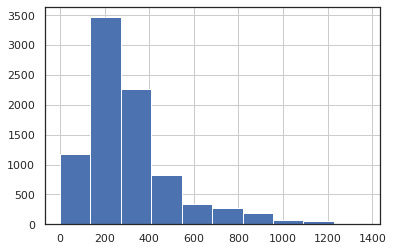

In [64]:
submission['monthlyRent(us_dollar)'].hist()